In [1]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

## Load the Data

We will use the Numenta Anomaly Benchmark(NAB) dataset. It provides artificial timeseries data containing labeled anomalous periods of behavior. Data are ordered, timestamped, single-valued metrics.

We will use the art_daily_small_noise.csv file for training and the art_daily_jumpsup.csv file for testing. The simplicity of this dataset allows us to demonstrate anomaly detection effectively.

In [2]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

df_train = df_small_noise
df_test = df_daily_jumpsup

### Quick look at train data

In [3]:
df_train.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


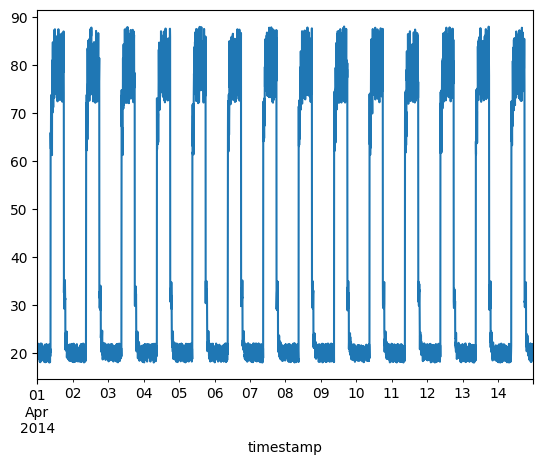

In [4]:
fig, ax = plt.subplots()
df_train.plot(legend=False, ax=ax)
plt.show()

### Quick look at test data

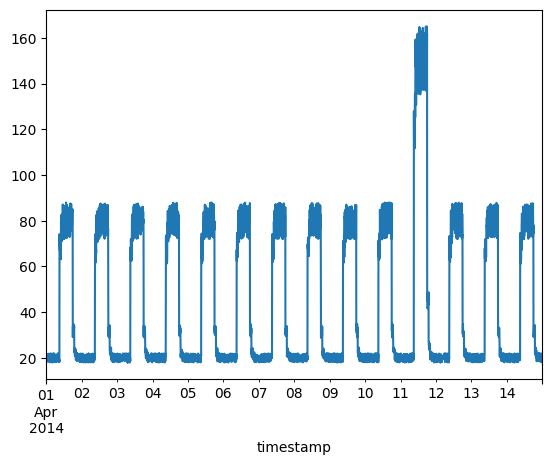

In [5]:
fig, ax = plt.subplots()
df_test.plot(legend=False, ax=ax)
plt.show()

In [6]:
training_mean = df_train.mean()
training_std = df_train.std()
df_training_value = (df_train - training_mean) / training_std
df_test_value = (df_test - training_mean) / training_std

print(df_training_value)

                        value
timestamp                    
2014-04-01 00:00:00 -0.858829
2014-04-01 00:05:00 -0.728993
2014-04-01 00:10:00 -0.848148
2014-04-01 00:15:00 -0.729586
2014-04-01 00:20:00 -0.731173
...                       ...
2014-04-14 23:35:00 -0.791647
2014-04-14 23:40:00 -0.780255
2014-04-14 23:45:00 -0.833640
2014-04-14 23:50:00 -0.735102
2014-04-14 23:55:00 -0.846089

[4032 rows x 1 columns]


**Data Time Period**

## Data Preprocessing

#### 2. Data Scaling

In [7]:
# scaler = StandardScaler()
# scaler = scaler.fit(np.array(df_train['value']).reshape(-1,1))

# df_train['scaled_value'] = scaler.transform(np.array(df_train['value']).reshape(-1,1))
# df_test['scaled_value'] = scaler.transform(np.array(df_test['value']).reshape(-1,1))

In [8]:
df_train.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


#### 3. Create sequences
- Create sequences combining `TIME_STEPS` contiguous data values from the training data.
- `TIME_STEP` is set 2 as we want our network to have memory of last 2 days.

In [9]:
TIME_STEPS=288

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


X_train = create_sequences(df_training_value.values)
print("Training input shape: ", X_train.shape)

X_test = create_sequences(df_test_value.values)
print("Testing input shape: ", X_test.shape)

Training input shape:  (3745, 288, 1)
Testing input shape:  (3745, 288, 1)


In [10]:
# set seed to regenerate same sequence of random numbers. 
np.random.seed(21)
tf.random.set_seed(21)

## Build a model

We are building LSTM Autoencoder model. The model will take input of shape `(batch_size, sequence_length, num_features)` and return output of the same shape. In this case, `sequence_length is 30` and `num_features is 1`.

In [11]:
# from keras import layers
# model = keras.Sequential(
#     [
#         layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
#         layers.Conv1D(filters=32,kernel_size=7,padding="same",strides=2,activation="relu",),
#         layers.Dropout(rate=0.2),
#         layers.Conv1D(filters=16,kernel_size=7,padding="same",strides=2,activation="relu",),
#         layers.Conv1DTranspose(filters=16,kernel_size=7,padding="same",strides=2,activation="relu",),
#         layers.Dropout(rate=0.2),
#         layers.Conv1DTranspose(filters=32,kernel_size=7,padding="same",strides=2,activation="relu",),
#         layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
#     ]
# )
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
# model.summary()

In [12]:
# Encoder 
encoder = Sequential()
encoder.add(LSTM(256, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
encoder.add(LSTM(64, activation='tanh'))
encoder.add(Dropout(rate=0.1))
encoder.add(RepeatVector(X_train.shape[1]))
# Decoder 
decoder = Sequential()
decoder.add(LSTM(64, activation='tanh', return_sequences=True))
decoder.add(LSTM(256, activation='tanh', return_sequences=True))
decoder.add(Dropout(rate=0.1))
decoder.add(TimeDistributed(Dense(X_train.shape[2])))

# Autoencoder
model = Sequential([encoder, decoder])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

## Train Model

In [13]:
history = model.fit(X_train,
                    X_train,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')])

Epoch 1/50
27/27 [==============================] - 234s 8s/step - loss: 0.9877 - val_loss: 0.9740
Epoch 2/50
27/27 [==============================] - 261s 10s/step - loss: 0.9376 - val_loss: 0.9415
Epoch 3/50
27/27 [==============================] - 220s 8s/step - loss: 0.9347 - val_loss: 0.9720
Epoch 4/50
27/27 [==============================] - 251s 9s/step - loss: 0.9399 - val_loss: 0.9395
Epoch 5/50
27/27 [==============================] - 308s 12s/step - loss: 0.9346 - val_loss: 0.9280
Epoch 6/50
27/27 [==============================] - 397s 15s/step - loss: 0.9103 - val_loss: 0.9130
Epoch 7/50
27/27 [==============================] - 448s 17s/step - loss: 0.9211 - val_loss: 0.9264
Epoch 8/50
27/27 [==============================] - 378s 14s/step - loss: 0.9174 - val_loss: 0.9399
Epoch 9/50
27/27 [==============================] - 346s 13s/step - loss: 0.9289 - val_loss: 0.9386
Epoch 10/50
27/27 [==============================] - 371s 14s/step - loss: 0.9628 - val_loss: 0.9590
Ep

#### Plot Training - Validation loss

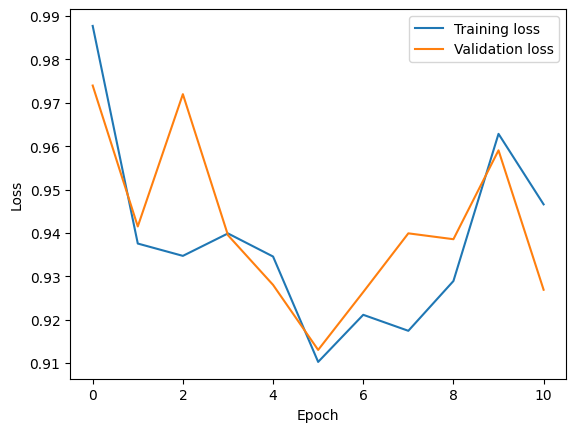

In [14]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [15]:
# X_train_pred = model.predict(X_train)
# plt.plot(X_train[0])
# plt.plot(X_train_pred[0])
# plt.show()

In [16]:
# Mean Absolute Error loss
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)
#threshold = threshold + 0.10*threshold

print('Reconstruction error threshold:',threshold)

NameError: name 'X_train_pred' is not defined

## Predict Anomalies on test data using threshold

118/118 [==============================] - 1s 7ms/step


Text(0, 0.5, 'Number of samples')

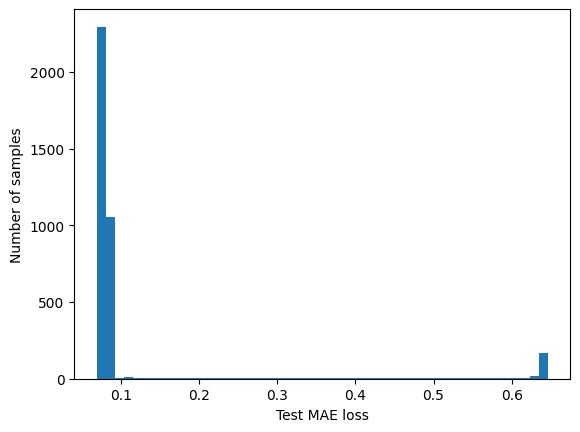

In [ ]:
X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [ ]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  425
Indices of anomaly samples:  (array([ 744,  764,  770,  772,  773,  774,  775,  776,  777,  778,  781,
        789,  790,  791,  793,  794,  970,  973,  974, 1942, 2519, 2521,
       2524, 2696, 2698, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708,
       2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719,
       2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730,
       2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741,
       2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752,
       2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763,
       2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774,
       2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785,
       2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796,
       2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807,
       2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2

In [ ]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

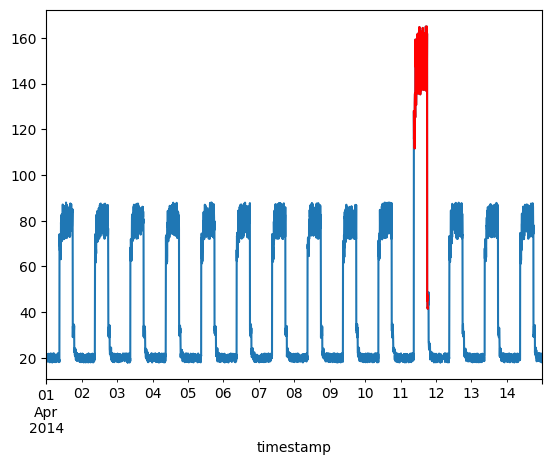

In [ ]:
df_subset = df_test.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_test.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()